# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print "TensorFlow Version {}".format(tf.__version__)

TensorFlow Version 1.3.0


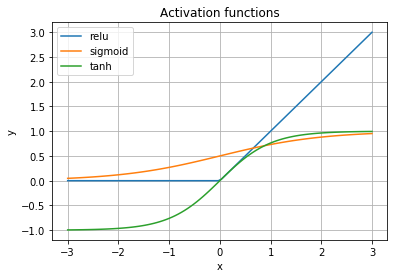

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [4]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    

    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
	import os
	all_batches = []
	all_labels = []
	for b in range(1,6):
		f_train_curr = os.path.join('data/cifar-10-batches-py', 'data_batch_%d' % (b, ))
		d = unpickle(f_train_curr)
		all_batches.append(d[0].reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1]).astype("float32"))
		all_labels.append(np.array(d[1]))
	data_train = np.concatenate(all_batches)
	labels_train = np.concatenate(all_labels)
	del d
	data_val = data_train[num_training:num_training+num_validation,:,:,:]
	labels_val = labels_train[num_training:num_training+num_validation]
	data_train = data_train[0:num_training,:,:,:]
	labels_train = labels_train[0:num_training]
	return data_train, labels_train, data_val, labels_val
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
	import os
	f_test = os.path.join("data/cifar-10-batches-py", 'test_batch')
	d = unpickle(f_test)
	data_test = d[0].reshape([-1, 3, 32, 32]).transpose([0, 2, 3, 1]).astype("float32")
	labels_test = np.array(d[1])
	return data_test, labels_test
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [5]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def full_connected(input_layer,output_units):
    return tf.layers.dense(input_layer, output_units)

def flatten(input_layer):
    return tf.contrib.layers.flatten(input_layer)

def batch_norm(input, train):
    return tf.contrib.layers.batch_norm(input, center=True, scale=True, is_training=train, scope='normalisation')

def dropout(input,keep_prob):
    return tf.nn.dropout(input, keep_prob)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [19]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1,5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3,2)   
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = full_connected(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)

            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = full_connected(self.relu3,10)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(5e-4, global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_, self.is_train: True, self.keep_prob: 0.6}                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.plot(losses)
            plt.title('training loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()    

            # Graph 2. X: epoch, Y: training accuracy
            plt.plot(accuracies)
            plt.title('training accuracy')
            plt.xlabel(' epoch')
            plt.ylabel('accuracy')
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y: Y_, self.is_train: True,  self.keep_prob: 0.6}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 18.921, accuracy = 0.141
iteration (50): loss = 1.919, accuracy = 0.297
iteration (100): loss = 1.650, accuracy = 0.398
iteration (150): loss = 1.698, accuracy = 0.352
iteration (200): loss = 1.747, accuracy = 0.367
iteration (250): loss = 1.638, accuracy = 0.422
iteration (300): loss = 1.438, accuracy = 0.484
iteration (350): loss = 1.579, accuracy = 0.414


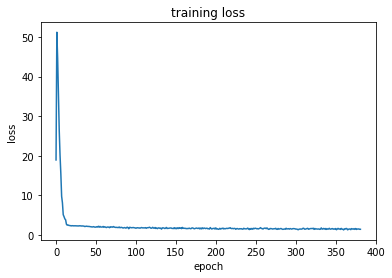

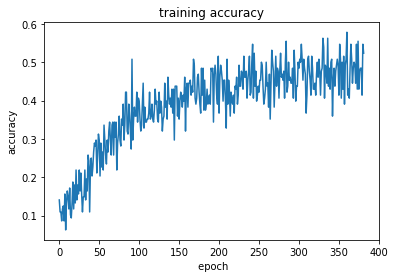

validation for epoch 0
-  epoch 0: validation accuracy = 0.492
train for epoch 1
iteration (400): loss = 1.459, accuracy = 0.469
iteration (450): loss = 1.431, accuracy = 0.508
iteration (500): loss = 1.397, accuracy = 0.477
iteration (550): loss = 1.183, accuracy = 0.641
iteration (600): loss = 1.422, accuracy = 0.516
iteration (650): loss = 1.381, accuracy = 0.508
iteration (700): loss = 1.215, accuracy = 0.578
iteration (750): loss = 1.178, accuracy = 0.586


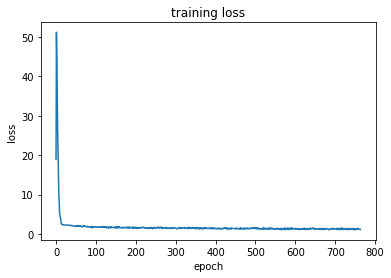

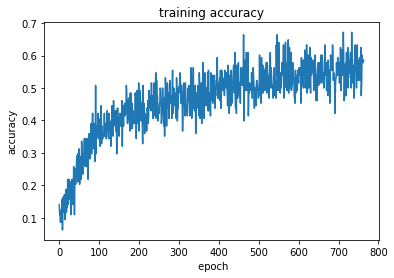

validation for epoch 1
-  epoch 1: validation accuracy = 0.548
train for epoch 2
iteration (800): loss = 1.201, accuracy = 0.531
iteration (850): loss = 1.273, accuracy = 0.586
iteration (900): loss = 1.109, accuracy = 0.648
iteration (950): loss = 1.091, accuracy = 0.594
iteration (1000): loss = 1.050, accuracy = 0.641
iteration (1050): loss = 1.169, accuracy = 0.594
iteration (1100): loss = 1.075, accuracy = 0.633


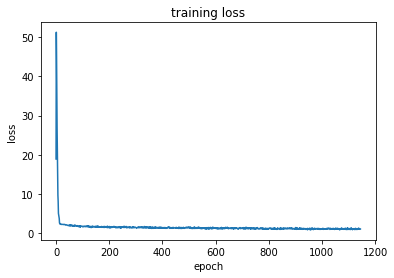

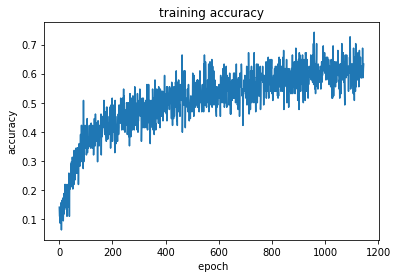

validation for epoch 2
-  epoch 2: validation accuracy = 0.542
train for epoch 3
iteration (1150): loss = 1.119, accuracy = 0.648
iteration (1200): loss = 0.994, accuracy = 0.648
iteration (1250): loss = 1.137, accuracy = 0.617
iteration (1300): loss = 1.124, accuracy = 0.609
iteration (1350): loss = 0.901, accuracy = 0.695
iteration (1400): loss = 1.052, accuracy = 0.672
iteration (1450): loss = 0.800, accuracy = 0.719
iteration (1500): loss = 0.939, accuracy = 0.656


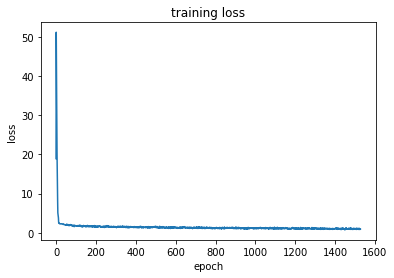

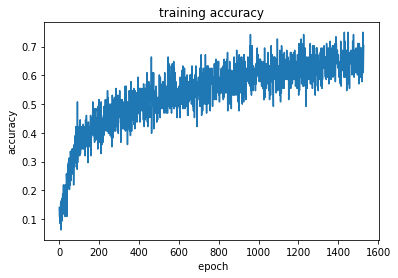

validation for epoch 3
-  epoch 3: validation accuracy = 0.597
train for epoch 4
iteration (1550): loss = 0.714, accuracy = 0.727
iteration (1600): loss = 0.893, accuracy = 0.648
iteration (1650): loss = 0.883, accuracy = 0.688
iteration (1700): loss = 1.026, accuracy = 0.625
iteration (1750): loss = 0.960, accuracy = 0.633
iteration (1800): loss = 0.980, accuracy = 0.633
iteration (1850): loss = 1.016, accuracy = 0.664
iteration (1900): loss = 0.730, accuracy = 0.750


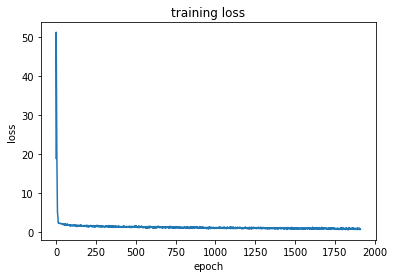

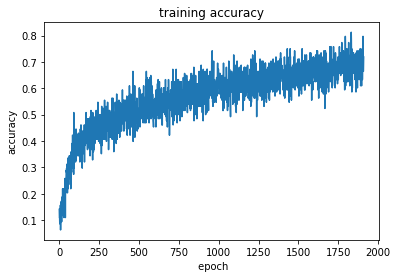

validation for epoch 4
-  epoch 4: validation accuracy = 0.588
***** test accuracy: 0.597
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [20]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [17]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 20

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 64)
            self.relu1 = tf.nn.relu(self.conv1)
        #with tf.variable_scope('conv5'):
         #   self.conv5 = conv2d(self.relu1, 5, 1, 32)
        #   self.relu8 = tf.nn.relu(self.conv5)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.batch_norm = batch_norm(self.pool1,self.is_train)
            self.conv2 = conv2d(self.batch_norm, 6, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            print('conv2 layer: ' + str(self.relu2.get_shape()))


        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.relu2, 5, 1, 64)
            self.relu3 = tf.nn.relu(self.conv3)
            self.pool3 = max_pool(self.relu3, 3, 2)            
            print('conv3 layer: ' + str(self.pool3.get_shape()))

        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.pool3,4, 1, 64)
            self.relu4 = tf.nn.relu(self.conv4)
            self.pool4 = max_pool(self.relu4, 3, 2)   
            print('conv4 layer: ' + str(self.pool4.get_shape()))


        self.flat = flatten(self.pool4)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc1'):
            self.fc1 = full_connected(self.flat, 512)
            self.drop1 = dropout(self.fc1, self.keep_prob)
            self.relu5 = tf.nn.relu(self.drop1)
            print('fc1 layer: ' + str(self.relu5.get_shape()))

        with tf.variable_scope('fc2'):
            self.batch_norm1 = batch_norm(self.relu5,self.is_train)
            self.fc2 = full_connected(self.batch_norm1, 256)
            self.relu5 = tf.nn.relu(self.fc2)
            print('fc2 layer: ' + str(self.relu5.get_shape()))


        with tf.variable_scope('fc3'):
            self.drop3= dropout(self.relu5, self.keep_prob)
            self.fc3 = full_connected(self.drop3,10)            
            print('fc3 layer: ' + str(self.fc3.get_shape()))        

        return self.fc3
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################
    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)

    def _build_optimizer(self):
        # Adam optimizer
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(1e-3, global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op)
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))

    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X: X_, self.Y: Y_, self.is_train: True, self.keep_prob: 0.5}                
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Graph 1. X: epoch, Y: training loss
            plt.plot(losses)
            plt.title('training loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()    

            # Graph 2. X: epoch, Y: training accuracy
            plt.plot(accuracies)
            plt.title('training accuracy')
            plt.xlabel(' epoch')
            plt.ylabel('accuracy')
            plt.show()

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            feed_dict = {self.X: X_, self.Y: Y_, self.is_train: True,  self.keep_prob: 0.5}

            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 64)
conv2 layer: (?, 16, 16, 64)
conv3 layer: (?, 8, 8, 64)
conv4 layer: (?, 4, 4, 64)
flat layer: (?, 1024)
fc1 layer: (?, 512)
fc2 layer: (?, 256)
fc3 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.912, accuracy = 0.133
iteration (50): loss = 2.079, accuracy = 0.281
iteration (100): loss = 1.906, accuracy = 0.328
iteration (150): loss = 1.897, accuracy = 0.289
iteration (200): loss = 1.840, accuracy = 0.320
iteration (250): loss = 1.825, accuracy = 0.375
iteration (300): loss = 1.650, accuracy = 0.383
iteration (350): loss = 1.662, accuracy = 0.336


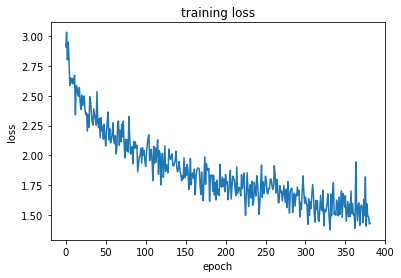

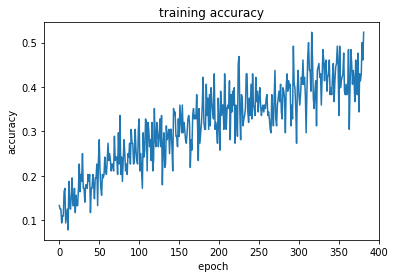

validation for epoch 0
-  epoch 0: validation accuracy = 0.449
train for epoch 1
iteration (400): loss = 1.438, accuracy = 0.469
iteration (450): loss = 1.420, accuracy = 0.492
iteration (500): loss = 1.504, accuracy = 0.492
iteration (550): loss = 1.284, accuracy = 0.531
iteration (600): loss = 1.188, accuracy = 0.547
iteration (650): loss = 1.520, accuracy = 0.430
iteration (700): loss = 1.431, accuracy = 0.477
iteration (750): loss = 1.228, accuracy = 0.547


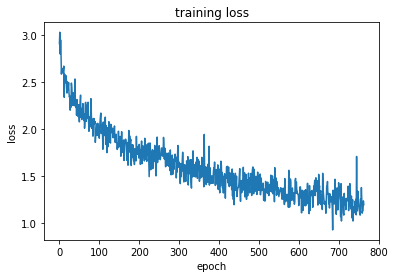

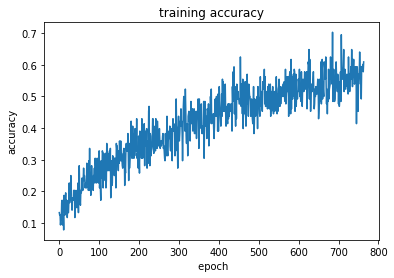

validation for epoch 1
-  epoch 1: validation accuracy = 0.561
train for epoch 2
iteration (800): loss = 1.036, accuracy = 0.547
iteration (850): loss = 1.214, accuracy = 0.555
iteration (900): loss = 1.137, accuracy = 0.656
iteration (950): loss = 1.068, accuracy = 0.633
iteration (1000): loss = 1.050, accuracy = 0.648
iteration (1050): loss = 0.981, accuracy = 0.695
iteration (1100): loss = 0.964, accuracy = 0.641


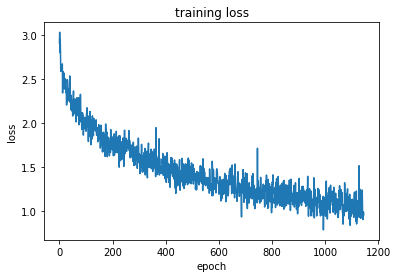

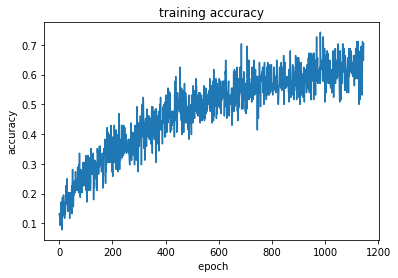

validation for epoch 2
-  epoch 2: validation accuracy = 0.646
train for epoch 3
iteration (1150): loss = 1.010, accuracy = 0.625
iteration (1200): loss = 0.867, accuracy = 0.711
iteration (1250): loss = 1.055, accuracy = 0.633
iteration (1300): loss = 1.196, accuracy = 0.609
iteration (1350): loss = 0.782, accuracy = 0.758
iteration (1400): loss = 0.896, accuracy = 0.695
iteration (1450): loss = 0.845, accuracy = 0.719
iteration (1500): loss = 0.710, accuracy = 0.727


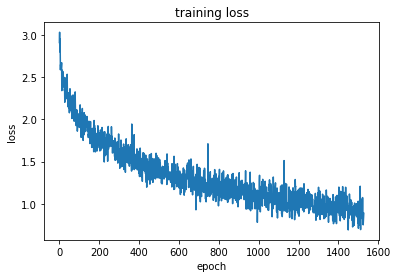

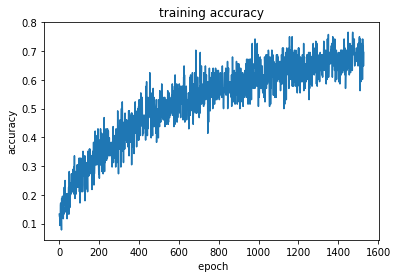

validation for epoch 3
-  epoch 3: validation accuracy = 0.681
train for epoch 4
iteration (1550): loss = 0.785, accuracy = 0.695
iteration (1600): loss = 0.821, accuracy = 0.703
iteration (1650): loss = 1.035, accuracy = 0.617
iteration (1700): loss = 0.878, accuracy = 0.648
iteration (1750): loss = 0.904, accuracy = 0.688
iteration (1800): loss = 0.777, accuracy = 0.695
iteration (1850): loss = 0.943, accuracy = 0.680
iteration (1900): loss = 0.748, accuracy = 0.734


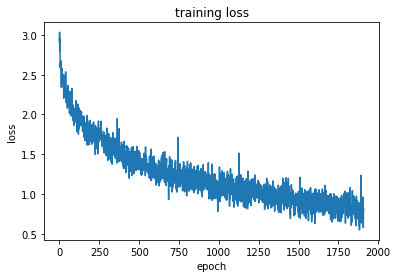

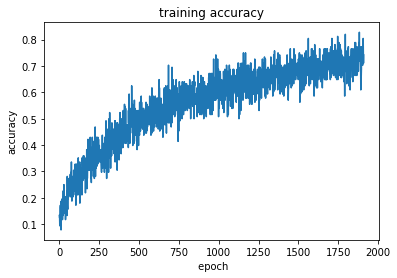

validation for epoch 4
-  epoch 4: validation accuracy = 0.703
train for epoch 5
iteration (1950): loss = 0.821, accuracy = 0.695
iteration (2000): loss = 0.629, accuracy = 0.773
iteration (2050): loss = 0.837, accuracy = 0.742
iteration (2100): loss = 0.722, accuracy = 0.758
iteration (2150): loss = 0.997, accuracy = 0.648
iteration (2200): loss = 0.834, accuracy = 0.703
iteration (2250): loss = 0.603, accuracy = 0.758


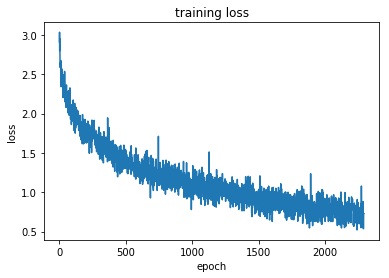

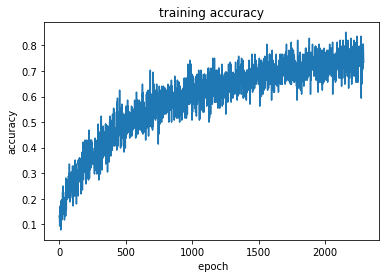

validation for epoch 5
-  epoch 5: validation accuracy = 0.740
train for epoch 6
iteration (2300): loss = 0.704, accuracy = 0.734
iteration (2350): loss = 0.639, accuracy = 0.797
iteration (2400): loss = 0.844, accuracy = 0.766
iteration (2450): loss = 0.686, accuracy = 0.742
iteration (2500): loss = 0.687, accuracy = 0.805
iteration (2550): loss = 0.651, accuracy = 0.773
iteration (2600): loss = 0.554, accuracy = 0.805
iteration (2650): loss = 0.689, accuracy = 0.758


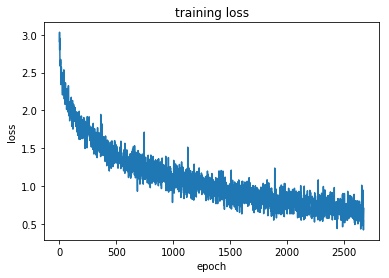

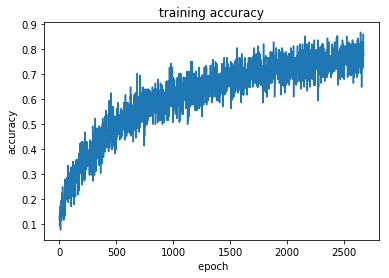

validation for epoch 6
-  epoch 6: validation accuracy = 0.737
train for epoch 7
iteration (2700): loss = 0.739, accuracy = 0.742
iteration (2750): loss = 0.773, accuracy = 0.719
iteration (2800): loss = 0.533, accuracy = 0.797
iteration (2850): loss = 0.477, accuracy = 0.820
iteration (2900): loss = 0.570, accuracy = 0.820
iteration (2950): loss = 0.668, accuracy = 0.766
iteration (3000): loss = 0.517, accuracy = 0.828
iteration (3050): loss = 0.454, accuracy = 0.844


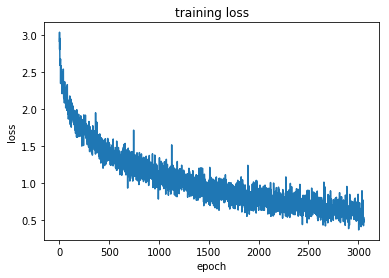

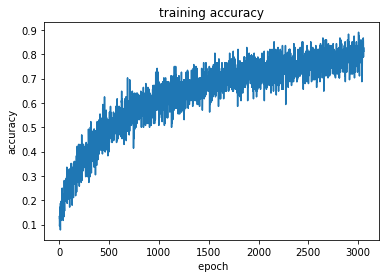

validation for epoch 7
-  epoch 7: validation accuracy = 0.752
train for epoch 8
iteration (3100): loss = 0.670, accuracy = 0.781
iteration (3150): loss = 0.639, accuracy = 0.742
iteration (3200): loss = 0.636, accuracy = 0.781
iteration (3250): loss = 0.694, accuracy = 0.773
iteration (3300): loss = 0.537, accuracy = 0.812
iteration (3350): loss = 0.764, accuracy = 0.773
iteration (3400): loss = 0.586, accuracy = 0.797


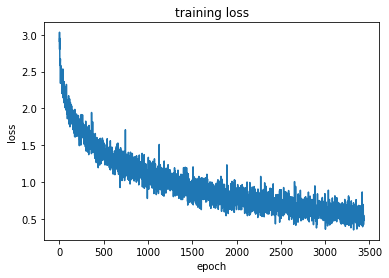

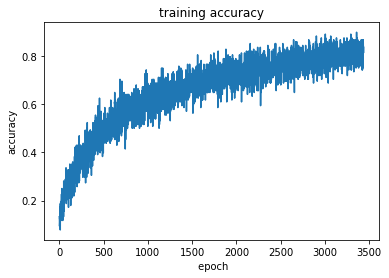

validation for epoch 8
-  epoch 8: validation accuracy = 0.733
train for epoch 9
iteration (3450): loss = 0.532, accuracy = 0.828
iteration (3500): loss = 0.588, accuracy = 0.812
iteration (3550): loss = 0.579, accuracy = 0.789
iteration (3600): loss = 0.456, accuracy = 0.828
iteration (3650): loss = 0.609, accuracy = 0.805
iteration (3700): loss = 0.519, accuracy = 0.812
iteration (3750): loss = 0.529, accuracy = 0.836
iteration (3800): loss = 0.488, accuracy = 0.859


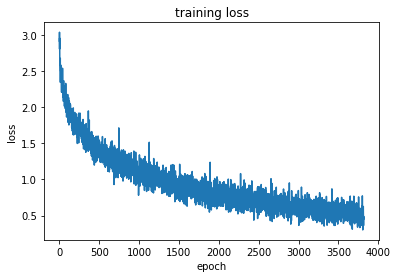

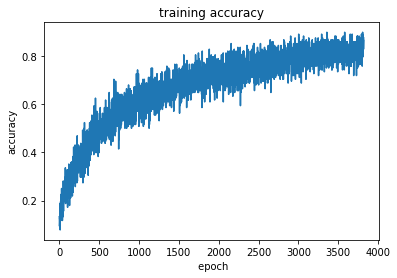

validation for epoch 9
-  epoch 9: validation accuracy = 0.734
train for epoch 10
iteration (3850): loss = 0.385, accuracy = 0.875
iteration (3900): loss = 0.533, accuracy = 0.805
iteration (3950): loss = 0.595, accuracy = 0.781
iteration (4000): loss = 0.628, accuracy = 0.805
iteration (4050): loss = 0.367, accuracy = 0.891
iteration (4100): loss = 0.507, accuracy = 0.812
iteration (4150): loss = 0.298, accuracy = 0.906
iteration (4200): loss = 0.476, accuracy = 0.852


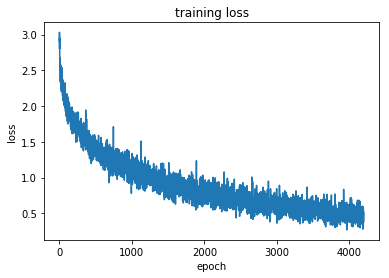

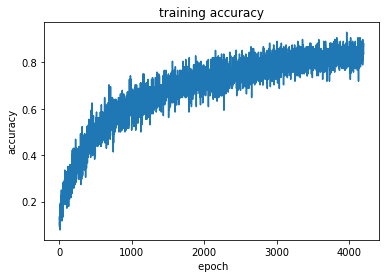

validation for epoch 10
-  epoch 10: validation accuracy = 0.760
train for epoch 11
iteration (4250): loss = 0.420, accuracy = 0.844
iteration (4300): loss = 0.511, accuracy = 0.812
iteration (4350): loss = 0.566, accuracy = 0.781
iteration (4400): loss = 0.463, accuracy = 0.852
iteration (4450): loss = 0.492, accuracy = 0.812
iteration (4500): loss = 0.416, accuracy = 0.891
iteration (4550): loss = 0.407, accuracy = 0.875


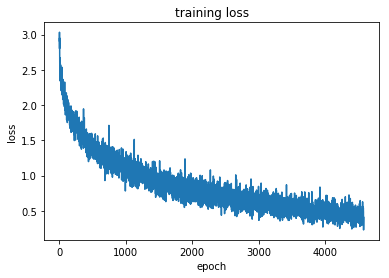

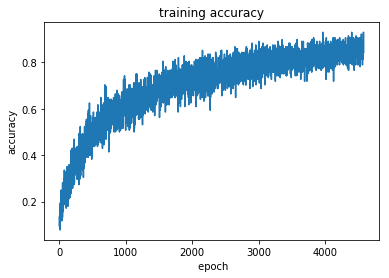

validation for epoch 11
-  epoch 11: validation accuracy = 0.760
train for epoch 12
iteration (4600): loss = 0.291, accuracy = 0.906
iteration (4650): loss = 0.488, accuracy = 0.836
iteration (4700): loss = 0.447, accuracy = 0.844
iteration (4750): loss = 0.500, accuracy = 0.852
iteration (4800): loss = 0.277, accuracy = 0.914
iteration (4850): loss = 0.301, accuracy = 0.914
iteration (4900): loss = 0.442, accuracy = 0.852
iteration (4950): loss = 0.477, accuracy = 0.820


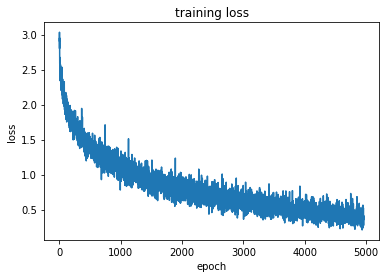

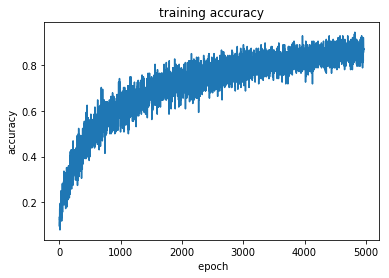

validation for epoch 12
-  epoch 12: validation accuracy = 0.756
train for epoch 13
iteration (5000): loss = 0.294, accuracy = 0.875
iteration (5050): loss = 0.332, accuracy = 0.875
iteration (5100): loss = 0.319, accuracy = 0.898
iteration (5150): loss = 0.274, accuracy = 0.891
iteration (5200): loss = 0.360, accuracy = 0.875
iteration (5250): loss = 0.412, accuracy = 0.883
iteration (5300): loss = 0.298, accuracy = 0.914


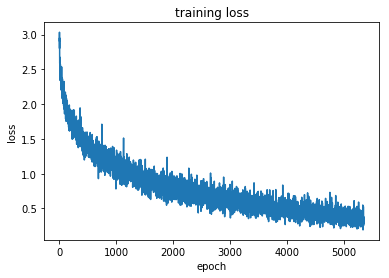

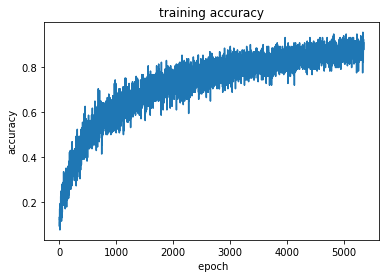

validation for epoch 13
-  epoch 13: validation accuracy = 0.763
train for epoch 14
iteration (5350): loss = 0.364, accuracy = 0.891
iteration (5400): loss = 0.371, accuracy = 0.898
iteration (5450): loss = 0.310, accuracy = 0.891
iteration (5500): loss = 0.341, accuracy = 0.859
iteration (5550): loss = 0.353, accuracy = 0.875
iteration (5600): loss = 0.331, accuracy = 0.898
iteration (5650): loss = 0.225, accuracy = 0.914
iteration (5700): loss = 0.323, accuracy = 0.898


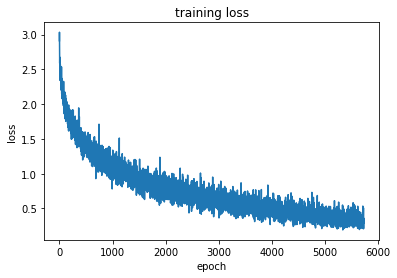

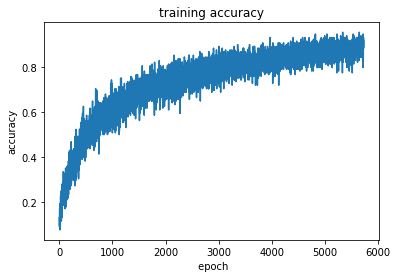

validation for epoch 14
-  epoch 14: validation accuracy = 0.754
train for epoch 15
iteration (5750): loss = 0.192, accuracy = 0.922
iteration (5800): loss = 0.364, accuracy = 0.859
iteration (5850): loss = 0.327, accuracy = 0.906
iteration (5900): loss = 0.277, accuracy = 0.898
iteration (5950): loss = 0.204, accuracy = 0.922
iteration (6000): loss = 0.540, accuracy = 0.828
iteration (6050): loss = 0.337, accuracy = 0.891
iteration (6100): loss = 0.338, accuracy = 0.883


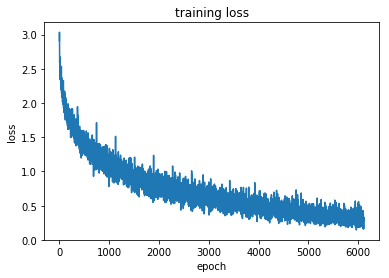

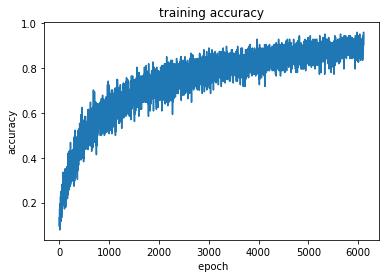

validation for epoch 15
-  epoch 15: validation accuracy = 0.767
train for epoch 16
iteration (6150): loss = 0.399, accuracy = 0.867
iteration (6200): loss = 0.324, accuracy = 0.906
iteration (6250): loss = 0.246, accuracy = 0.922
iteration (6300): loss = 0.277, accuracy = 0.906
iteration (6350): loss = 0.363, accuracy = 0.898
iteration (6400): loss = 0.459, accuracy = 0.836
iteration (6450): loss = 0.396, accuracy = 0.867


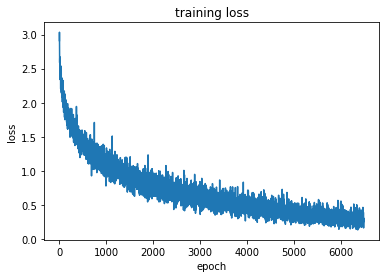

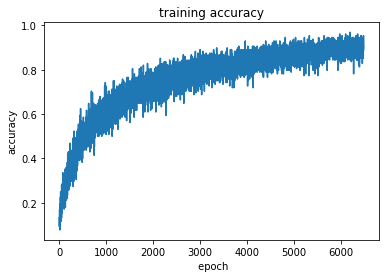

validation for epoch 16
-  epoch 16: validation accuracy = 0.758
train for epoch 17
iteration (6500): loss = 0.270, accuracy = 0.914
iteration (6550): loss = 0.399, accuracy = 0.891
iteration (6600): loss = 0.324, accuracy = 0.891
iteration (6650): loss = 0.322, accuracy = 0.883
iteration (6700): loss = 0.267, accuracy = 0.891
iteration (6750): loss = 0.319, accuracy = 0.883
iteration (6800): loss = 0.324, accuracy = 0.891
iteration (6850): loss = 0.266, accuracy = 0.914


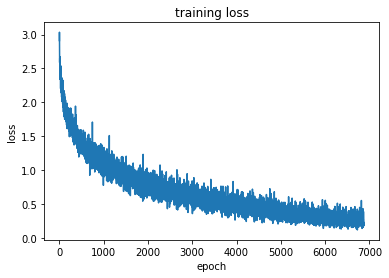

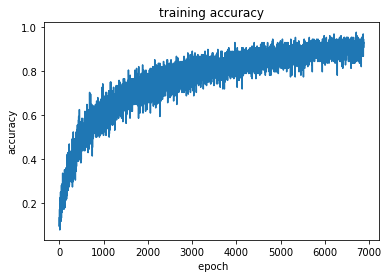

validation for epoch 17
-  epoch 17: validation accuracy = 0.769
train for epoch 18
iteration (6900): loss = 0.256, accuracy = 0.930
iteration (6950): loss = 0.261, accuracy = 0.930
iteration (7000): loss = 0.284, accuracy = 0.891
iteration (7050): loss = 0.298, accuracy = 0.891
iteration (7100): loss = 0.287, accuracy = 0.898
iteration (7150): loss = 0.246, accuracy = 0.930
iteration (7200): loss = 0.344, accuracy = 0.875
iteration (7250): loss = 0.266, accuracy = 0.906


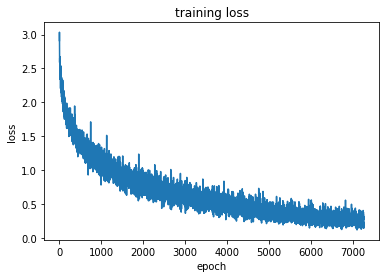

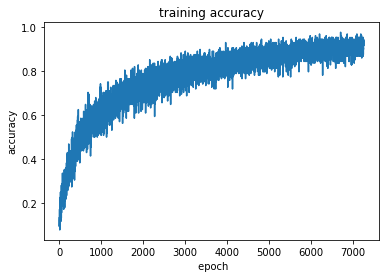

validation for epoch 18
-  epoch 18: validation accuracy = 0.782
train for epoch 19
iteration (7300): loss = 0.230, accuracy = 0.922
iteration (7350): loss = 0.371, accuracy = 0.859
iteration (7400): loss = 0.228, accuracy = 0.898
iteration (7450): loss = 0.217, accuracy = 0.906
iteration (7500): loss = 0.275, accuracy = 0.891
iteration (7550): loss = 0.225, accuracy = 0.906
iteration (7600): loss = 0.320, accuracy = 0.883


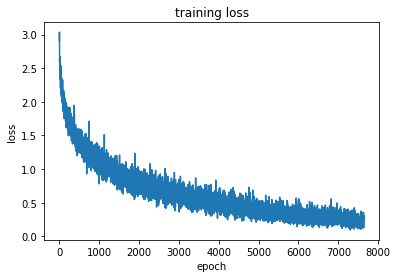

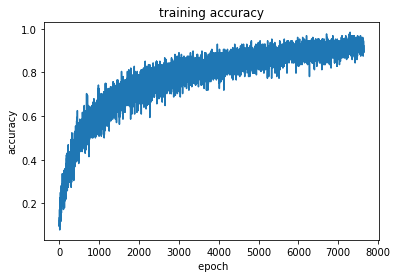

validation for epoch 19
-  epoch 19: validation accuracy = 0.758
***** test accuracy: 0.745


In [25]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
def pre_process_image(image):
    image = tf.image.random_flip_left_right(image)
        
    # Randomly adjust hue, contrast and saturation.
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

    # Limit the image pixels between [0, 1] in case of overflow.
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)

    return image

def pre_process(images):
    images = tf.map_fn(lambda image: pre_process_image(image), images)

    return images

X_train_ = X_train
X_val_ = X_val
X_test_ = X_test
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [26]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 64)
conv2 layer: (?, 16, 16, 64)
conv3 layer: (?, 8, 8, 64)
conv4 layer: (?, 4, 4, 64)
flat layer: (?, 1024)
fc1 layer: (?, 512)
fc2 layer: (?, 256)
fc3 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt


INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
